In [34]:
import os
import pandas as pd
import pandas as pd
import seaborn as sns
# Define the directory where your CSV files are stored
csv_dir = "../local/bbcpy_AutoML/logs/10_11/results/"
# "C:\Users\alioo\Desktop\MA\bbcpy_AutoML\local\bbcpy_AutoML\logs\10_11\results"

In [35]:
import os
import glob

# Path to the directory containing the files
file_path = "../local/bbcpy_AutoML/logs/11_11/results/"

# Pattern to match all csv files
pattern = os.path.join(file_path, "*.csv")

# List to hold dataframes
dataframes = []

# Iterate over files that match the csv pattern
for file in glob.glob(pattern):
    # Extract task name, model name, and subject name from the file name
    filename = os.path.basename(file)

    if len(filename.split("_")) == 3:
        task_name, model_name, subject_name = filename.split("_")
    else:
        task_name, _, model_name, subject_name = filename.split("_")
    
    subject_name = subject_name.split('.')[0]  # Remove the file extension
    
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Select and rename columns that contain "mean"
    string_to_check = 'mean'
    is_mean_in_columns = any(string_to_check in col for col in df.columns)

    # Select and rename columns that contain "mean"
    string_to_check = 'best'
    is_best_in_columns = any(string_to_check in col for col in df.columns)

    if is_mean_in_columns:
        wanted_columns = ['mean_test/acc' , 'mean_test/f1' , 'mean_val/acc' , 'mean_val/f1' ]
        df = df[df.columns[df.columns.isin(wanted_columns)]]
        mean_columns = [col for col in df.columns if 'mean' in col]
        df = df[mean_columns].rename(columns=lambda x: x.replace('mean_', ''))
        # # Combine the mean columns back into the dataframe
        # df = pd.concat([df, df_best], axis=1)
        
    elif is_best_in_columns:
        wanted_columns = ['val/acc_best', 'val/f1_best']
        df_best = df[df.columns[df.columns.isin(wanted_columns)]]
        # Remove the string "best" from remaining column names
        best_columns = [col for col in df_best.columns if 'best' in col]
        df_best = df_best[best_columns].rename(columns=lambda x: x.replace('_best', ''))

        wanted_columns = ['test/f1', 'test/acc']
        df_test = df[df.columns[df.columns.isin(wanted_columns)]]
    
        # Combine the mean columns back into the dataframe
        df = pd.concat([df_best, df_test], axis=1)
    
    # Add task, model, and subject as columns to the dataframe
    df['Task'] = task_name
    df['Model'] = model_name
    df['Subject'] = subject_name
    
    # Append to the list of dataframes
    dataframes.append(df)

# Combine all dataframes into a single dataframe
combined_data = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined dataframe
combined_data


,test/acc,test/f1,val/acc,val/f1,Task,Model,Subject
0,0.323188,0.309661,0.362419,0.327744,2D,csp-MNE,S1
1,0.429197,0.410579,0.448556,0.433679,2D,csp-MNE,S2
2,0.458065,0.440802,0.507006,0.500014,2D,csp-MNE,S20
3,0.348000,0.334608,0.391695,0.379413,2D,csp-MNE,S23
4,0.351938,0.268208,0.366807,0.308752,2D,csp-MNE,S26
...,...,...,...,...,...,...,...
203,0.934641,0.933333,0.966102,0.968750,LR,TSCeption,S52
204,0.954248,0.955414,0.983333,0.983051,LR,TSCeption,S57
205,0.963855,0.963415,1.000000,1.000000,LR,TSCeption,S60
206,0.935897,0.932735,0.976744,0.979167,LR,TSCeption,S8


In [42]:
combined_data.to_csv('out.csv', sep=',', index=True, header=True)

In [36]:
# Separate the data by task
df_2d = combined_data[combined_data['Task'] == '2D']
df_lr = combined_data[combined_data['Task'] == 'LR']

In [37]:
df_2d

,test/acc,test/f1,val/acc,val/f1,Task,Model,Subject
0,0.323188,0.309661,0.362419,0.327744,2D,csp-MNE,S1
1,0.429197,0.410579,0.448556,0.433679,2D,csp-MNE,S2
2,0.458065,0.440802,0.507006,0.500014,2D,csp-MNE,S20
3,0.348000,0.334608,0.391695,0.379413,2D,csp-MNE,S23
4,0.351938,0.268208,0.366807,0.308752,2D,csp-MNE,S26
...,...,...,...,...,...,...,...
95,0.821429,0.822643,0.880000,0.879072,2D,TSCeption,S52
96,0.747748,0.748245,0.697674,0.704799,2D,TSCeption,S57
97,0.728261,0.715110,0.756098,0.754171,2D,TSCeption,S60
98,0.719178,0.722042,0.758621,0.758717,2D,TSCeption,S8


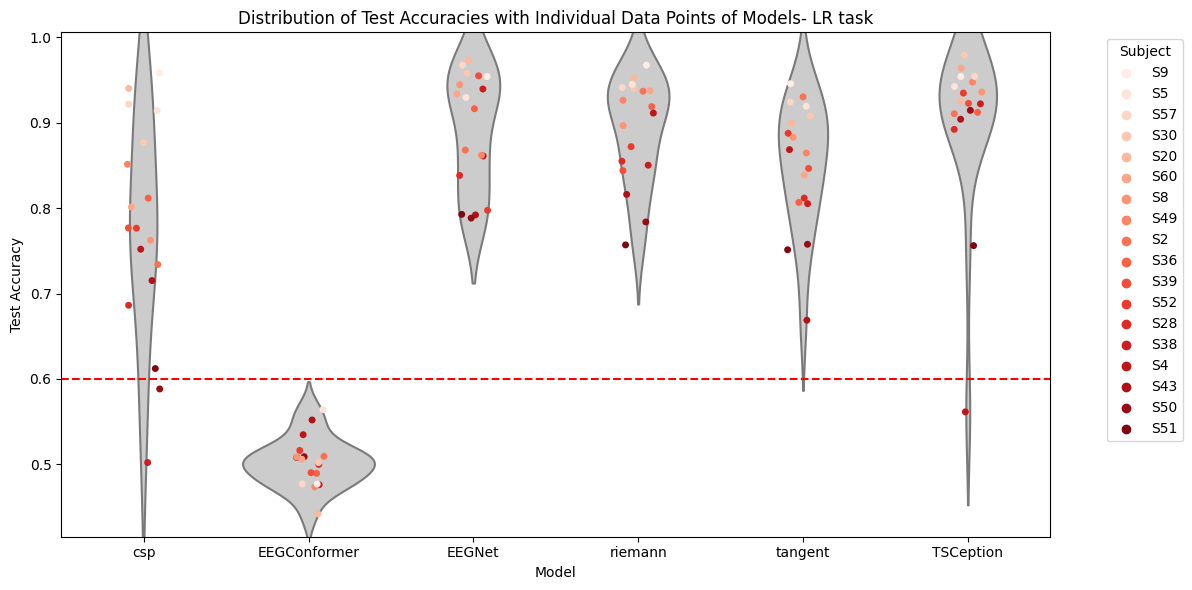

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


threshold_value = 0.6
column_name = "test/acc"  # Adjust based on your data

# Calculate mean score for each subject
subject_scores = df_lr.groupby('Subject')[column_name].mean().sort_values(ascending=False)

# Create a color palette from dark to light
palette = sns.color_palette("Reds", n_colors=len(subject_scores))

# Map subjects to colors based on their sorted scores
color_map = dict(zip(subject_scores.index, palette))

plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Model', y=column_name, data=df_lr, inner=None, color=".8")

# Overlay the individual data points with colors mapped to subjects
# Set the hue order to the sorted subjects
sns.stripplot(x='Model', y=column_name, data=df_lr, jitter=True, 
              hue='Subject', zorder=1, palette=color_map, hue_order=subject_scores.index)

# Draw a threshold line
plt.axhline(y=threshold_value, color='r', linestyle='--')

plt.title('Distribution of Test Accuracies with Individual Data Points of Models- LR task')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')

# Add legend outside the plot, sorted according to subject scores
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

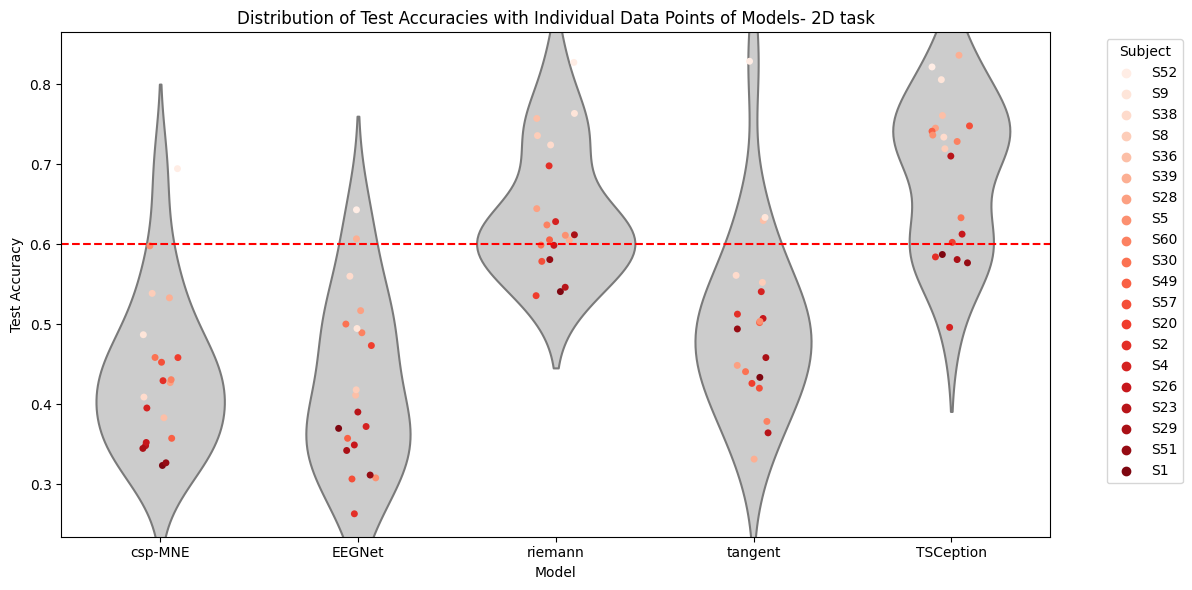

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


threshold_value = 0.6
column_name = "test/acc"  # Adjust based on your data

# Calculate mean score for each subject
subject_scores = df_2d.groupby('Subject')[column_name].mean().sort_values(ascending=False)

# Create a color palette from dark to light
palette = sns.color_palette("Reds", n_colors=len(subject_scores))

# Map subjects to colors based on their sorted scores
color_map = dict(zip(subject_scores.index, palette))

plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Model', y=column_name, data=df_2d, inner=None, color=".8")

# Overlay the individual data points with colors mapped to subjects
# Set the hue order to the sorted subjects
sns.stripplot(x='Model', y=column_name, data=df_2d, jitter=True, 
              hue='Subject', zorder=1, palette=color_map, hue_order=subject_scores.index)

# Draw a threshold line
plt.axhline(y=threshold_value, color='r', linestyle='--')

plt.title('Distribution of Test Accuracies with Individual Data Points of Models- 2D task')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')

# Add legend outside the plot, sorted according to subject scores
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
C1_list = ['S5', 'S60', 'S57', 'S39', 'S9', 'S49', 'S30', 'S51', 'S52', 'S8', 'S36', 'S20', 'S50', 'S4', 'S38', 'S2', 'S43', 'S28']
C2_list = ['S29', 'S26', 'S23', 'S19', 'S53', 'S41', 'S35', 'S61', 'S45', 'S14', 'S15', 'S11', 'S25', 'S1']
C3_list = ['S13', 'S10', 'S54', 'S32', 'S7', 'S58', 'S56', 'S48', 'S62', 'S34', 'S12', 'S33', 'S55', 'S22', 'S47', 'S16', 'S27', 'S18', 'S42', 'S31', 'S21', 'S24', 'S17', 'S6', 'S40', 'S3']